## Example curve prediction script
In this notebook we will try to predict the function coefficients.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from prettytable import PrettyTable
% matplotlib widget

from generate_TF import GenerateTF

# from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F


In [2]:
# Load the data
df = pd.read_pickle('./data/transfer-functions.pkl')
df.head()

,phi,g_oo,x,y
0,-20.0,0.0001,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-28.17844516431674, -29.995330137199815, -26...."
1,-20.0,0.0001,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-21.519000119295377, -20.82520269965962, -23...."
2,-20.0,0.0001,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-22.78282633317538, -23.116844835167647, -23...."
3,-20.0,0.0001,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-19.483532441089714, -25.181283644031062, -34..."
4,-20.0,0.0001,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-24.21908363783242, -27.164085696072963, -24...."


In [3]:
phi_encoder = preprocessing.LabelEncoder()
phi_encoder.fit(df['phi'])
print(phi_encoder.classes_)

gain_encoder = preprocessing.LabelEncoder()
gain_encoder.fit(df['g_oo'])
print(gain_encoder.classes_)


[-20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.
  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.
   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.]
[0.0001     0.00062105 0.00114211 0.00166316 0.00218421 0.00270526
 0.00322632 0.00374737 0.00426842 0.00478947 0.00531053 0.00583158
 0.00635263 0.00687368 0.00739474 0.00791579 0.00843684 0.00895789
 0.00947895 0.01      ]


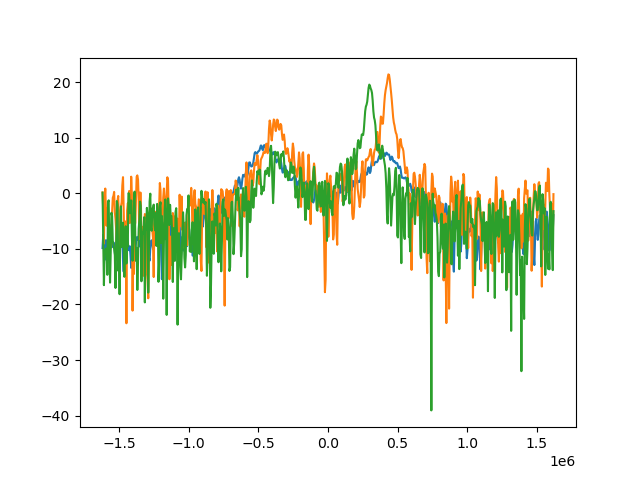

In [4]:
# Visualize the data
for index, row in df.sample(n=3).iterrows():
    y = row['y']
    x = row['x']
    plt.plot(x, y)
plt.show()

In [5]:
values = np.zeros((len(df), len(df.loc[0, 'y'])), dtype=np.float32)
# print(values.shape)
index = 0
for _, row in df.iterrows():
    values[index, :] = row['y']
    index += 1

data_scaler = preprocessing.StandardScaler().fit(values)


In [6]:
# Define the network architecture2
class Net(nn.Module):
    def __init__(self, n_inputs, n_outputs, name='classifer', activation_func=F.gelu,
                 hidden_1=140, hidden_2=110, hidden_3=0,
                 kernel_size=10, stride=10, trim_edges=120, save_best=True):
        super(Net, self).__init__()
        self.activate = activation_func
        self.name = name
        self.save_best = save_best
        # A layer that trims out the edges
        self.center = nn.ConstantPad1d(-trim_edges, 0)
        n_inputs -= 2 * trim_edges
        # An avgpooling layer to smoothen the curve
        padding = 0
        n_pool_out = (n_inputs + 2 * padding - kernel_size) // stride + 1
        self.pool1 = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=padding)

        # linear layer (n_pool_out -> hidden_1)
        self.fc1 = nn.Linear(n_pool_out, hidden_1)

        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)

        # linear layer (n_hidden -> n_outputs)
        if hidden_3 > 0:
            self.fc3 = nn.Linear(hidden_2, hidden_3)
            self.fc4 = nn.Linear(hidden_3, n_outputs)
        else:
            self.fc3 = nn.Linear(hidden_2, n_outputs)
            self.fc4 = None

        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # remove some points from the edges
        x = self.center(x)

        # This performs the average pooling layer
        x = self.pool1(x)

        # add hidden layer, with relu activation function
        x = self.activate(self.fc1(x))

        # add dropout layer
        x = self.dropout(x)

        # add hidden layer, with relu activation function
        x = self.activate(self.fc2(x))

        # add dropout layer
        x = self.dropout(x)

        if self.fc4:
            x = self.dropout(self.activate(self.fc3(x)))
            # add outputlayer
            x = self.fc4(x)
        else:
            # add output layer
            x = self.fc3(x)

        # Output layer with softmax activation
        x = F.log_softmax(x, dim=1)

        return x


In [7]:
# Initialize model, loss function and optimizer
# This is for the first parameter: phi
n_inputs = values.shape[1]
# we will build one model per output target
n_outputs = len(phi_encoder.classes_)
model1 = Net(n_inputs, n_outputs, name='classifier1', activation_func=F.gelu,
             hidden_1=420, hidden_2=140, hidden_3=0,
             kernel_size=4, stride=4, trim_edges=110, save_best=True)
print(model1)

# specify loss function (regression)
criterion = nn.NLLLoss();
criterion_name = 'NLL'
# criterion = nn.L1Loss(); criterion_name = 'MAE'

# specify optimizer
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01)


Net(
  (center): ConstantPad1d(padding=(-110, -110), value=0)
  (pool1): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (fc1): Linear(in_features=110, out_features=420, bias=True)
  (fc2): Linear(in_features=420, out_features=140, bias=True)
  (fc3): Linear(in_features=140, out_features=41, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [8]:
# Initialize model, loss function and optimizer
# This is for the second parameter: g_oo

n_inputs = values.shape[1]
# we will build one model per output target
n_outputs = len(gain_encoder.classes_)

model2 = Net(n_inputs, n_outputs, name='classifier2', activation_func=F.gelu,
             hidden_1=420, hidden_2=350, hidden_3=0,
             kernel_size=4, stride=4, trim_edges=120, save_best=True)
print(model2)

# specify loss function (regression)
criterion = nn.NLLLoss();
criterion_name = 'NLLLoss'
# criterion = nn.L1Loss(); criterion_name = 'MAE'

# specify optimizer
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)


Net(
  (center): ConstantPad1d(padding=(-120, -120), value=0)
  (pool1): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (fc1): Linear(in_features=105, out_features=420, bias=True)
  (fc2): Linear(in_features=420, out_features=350, bias=True)
  (fc3): Linear(in_features=350, out_features=20, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [9]:
# load model with the highest accuracy
# model1.load_state_dict(torch.load('models/model1.pt'))
# model2.load_state_dict(torch.load('models/model2.pt'))

model1.load_state_dict(torch.load('models/model1-classifier-acc53.pt'))
model2.load_state_dict(torch.load('models/model2-classifier-acc99.pt'))


<All keys matched successfully>

In [10]:
from generate_TF import GenerateTF
import torch
import torch.nn.functional as F


def curve_fit_deluxe(func, x, sample, trim_edges=0, kernel_size=1, stride=1, **kwargs):
    # center crop sample
    if trim_edges > 0:
        x, sample = x[trim_edges:-trim_edges], sample[trim_edges:-trim_edges]
    # convert to tensor for average pooling
    x = torch.tensor(x).view(1, -1)
    sample = torch.tensor(sample).view(1, -1)
    # average pool sample
    x = F.avg_pool1d(x, kernel_size=kernel_size, stride=stride).ravel().numpy()
    sample = F.avg_pool1d(sample, kernel_size=kernel_size, stride=stride).ravel().numpy()
    return curve_fit(func, x, sample, **kwargs)


This region is to use gradio and visualize predictions

-20.0 0.0001


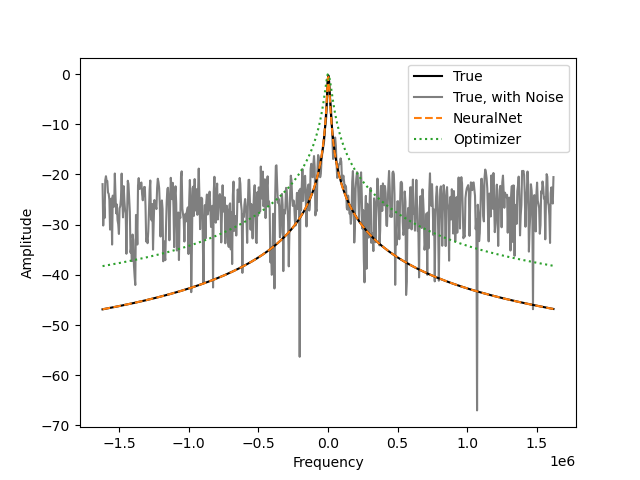

[['phase', -20.0, -12.0, -3.37], ['gain', 0.0001, 0.0001, 0.0003]]


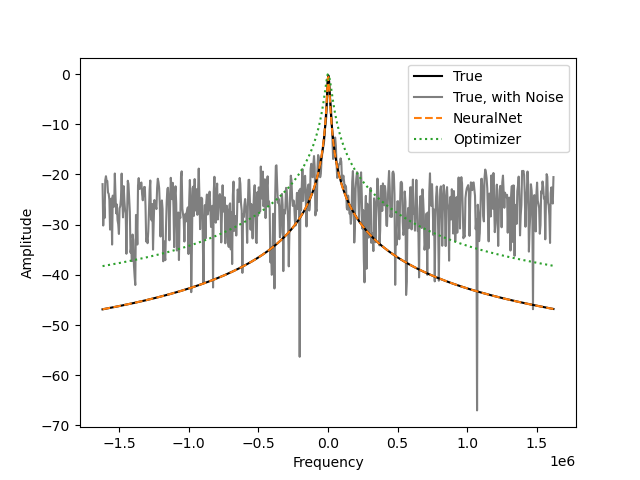

In [26]:

def classify(phase, gain):
    phase, gain = float(phase), float(gain)
    print(phase, gain)
    # table = PrettyTable()
    # table.field_names = ["param", "original", "model", "opt"]
    table = []
    gen_tf_noise = GenerateTF(fb_attn_index=3, with_noise=True)
    x = gen_tf_noise.frequency

    gen_tf_no_noise = GenerateTF(fb_attn_index=3, with_noise=False)

    # I get one input with given phase, gain from X_validate or y_validate
    y = gen_tf_noise(x, phase, gain)
    y_scaled = torch.tensor(data_scaler.transform([y]), dtype=torch.float32)
    phase_encoded = phi_encoder.transform([phase])
    gain_encoded = gain_encoder.transform([gain])

    # I make predictions with models + optimizer
    with torch.no_grad():
        pred_phase = model1(torch.atleast_2d(y_scaled))
        pred_gain = model2(torch.atleast_2d(y_scaled))

    # Extract top category
    _, pred_phase = torch.exp(pred_phase).topk(1, dim=1)
    _, pred_gain = torch.exp(pred_gain).topk(1, dim=1)

    # Get original value
    pred_phase = phi_encoder.inverse_transform(pred_phase.ravel().numpy())[0]
    pred_gain = gain_encoder.inverse_transform(pred_gain.ravel().numpy())[0]

    # Get optimizers results
    (opt_phase, opt_gain), _ = curve_fit_deluxe(gen_tf_no_noise, x, y, trim_edges=130,
                                                kernel_size=4, stride=1,
                                                bounds=([-20, 1e-4], [20, 1e-2]), method='trf')

    # I add them to the table
    table.append(['phase', float(np.round(phase, 2)), float(np.round(pred_phase, 2)), float(np.round(opt_phase, 2))])
    table.append(['gain', float(np.round(gain, 4)), float(np.round(pred_gain, 4)), float(np.round(opt_gain, 4))])

    # I plot them
    fig = plt.figure()
    p = plt.plot(x, gen_tf_no_noise(x, phase, gain), label=f'True', ls='-', color='black')
    plt.plot(x, gen_tf_noise(x, phase, gain), label=f'True, with Noise', ls='-', color='black', alpha=0.5)
    plt.plot(x, gen_tf_no_noise(x, pred_phase, pred_gain), label=f'NeuralNet',
             ls='--', color='tab:orange')
    plt.plot(x, gen_tf_no_noise(x, opt_phase, opt_gain), label=f'Optimizer',
             ls=':', color='tab:green')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.legend()
    # print(table.get_string())
    return fig, table

fig, table = classify(-20, 1e-4)
fig.show()
# print(table)

# return: an array (with the predicted/ real values) + a figure with the ploted lines

In [27]:
import gradio as gr

# print(gain_encoder.classes_.astype(str).tolist())
# build the gradio interface
interface = gr.Interface(fn=classify,
                         inputs=[
                             gr.Slider(label=f'Phase', minimum=-20., maximum=20., step=1.),
                             gr.Dropdown(label='Gain', choices=gain_encoder.classes_.astype(str).tolist(),
                                         type="value"),
                             # gr.Dropdown(["KNN", "SoftMax", "KerasShallow", "KerasDeep"], label='Choose Model'),
                         ],
                         outputs=[
                             gr.Plot(label='Graphical Evaluation'),
                             # gr.Textbox(lines=5),
                             gr.DataFrame(label='Numerical Evaluation',
                                          headers=['Param', 'True', 'NeuralNet', 'Optimizer'],
                                          datatype=['str', 'number', 'number', 'number'],
                                          row_count=2, col_count=(4, 'fixed'))
                         ],
                         interpretation="default",
                         )

interface.launch(debug=False)

Running on local URL:  http://127.0.0.1:7863/

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x7f5e43894bb0>, 'http://127.0.0.1:7863/', None)